In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random

In [2]:
inputBasePath = '/data'

In [3]:
trainingFolder = 'traffic_Data/DATA'
testingFolder = 'traffic_Data/TEST'
classes = pd.read_csv('labels.csv')
classes_size = len(classes)
print("Total number of classes: ", classes_size)

Total number of classes:  58


In [4]:
traffic_data = []
training_data = []
labels = []
def fetch_images(traffic_data, labels):
    for classValue in os.listdir(trainingFolder):
        classPath = os.path.join(trainingFolder, classValue)
        labels.append(classValue)
        for trafficSignal in os.listdir(classPath):
            imgTrafficSignal = Image.open(os.path.join(classPath,trafficSignal))
            imgTrafficSignal = imgTrafficSignal.convert("L")
            imgTrafficSignal = imgTrafficSignal.resize((90,90))
            imgTrafficSignal = np.array(imgTrafficSignal)
            traffic_data.append((imgTrafficSignal,[int(classValue)]))
    #training_data = np.array(training_data)
    labels = np.array(labels)
    return traffic_data, labels

In [5]:
traffic_data, labels = fetch_images(traffic_data, labels)
traffic_data_features, traffic_data_labels = zip(*traffic_data)
training_data_features, validation_data_features, training_data_labels, validation_data_labels = train_test_split(traffic_data_features, traffic_data_labels, test_size=0.33, random_state=42)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)
print(training_data_features.shape)
print(training_data_labels.shape)

(2793, 90, 90)
(2793, 1)


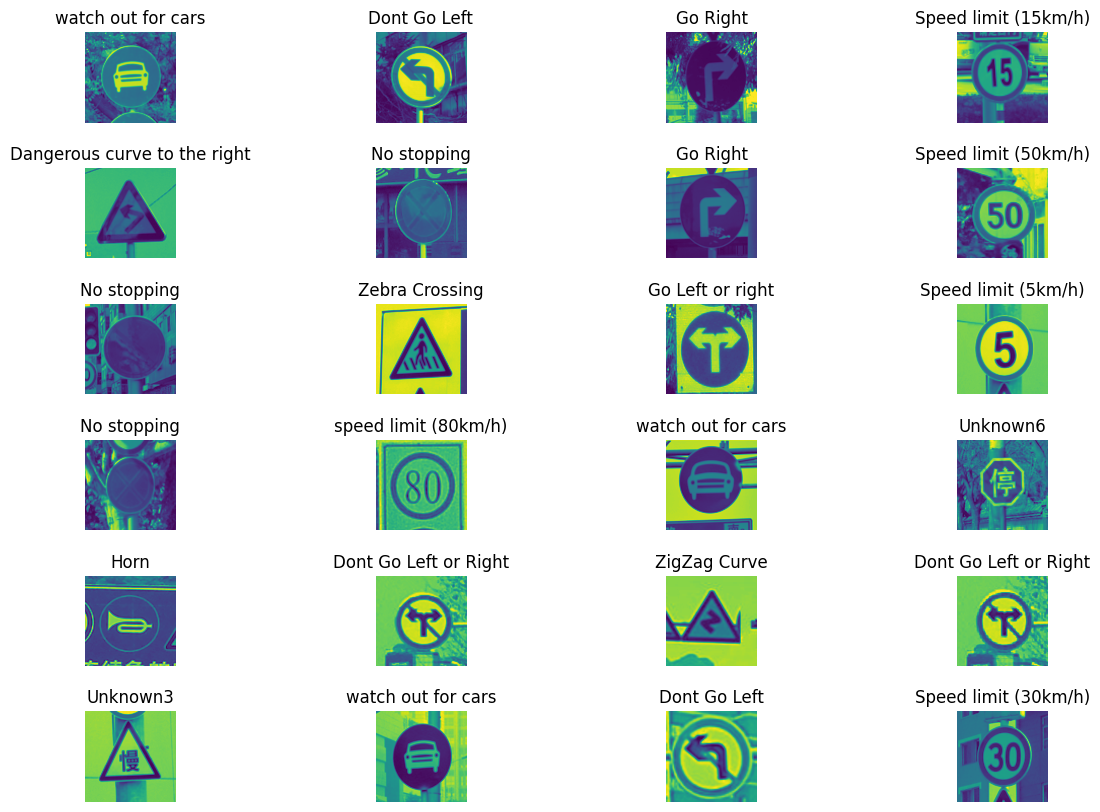

In [6]:
def imageDisplayer(data_features, data_labels_act, data_labels_pred=None):
    rows, cols = 6, 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    plt.subplots_adjust(wspace=0, hspace=0.5) 
    if data_labels_pred is not None:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col  # Calculate the index
                randomVal = random.randint(1,2)
                # Get the image and label for the current index
                display_image = data_features[i*randomVal]
                display_label_act = classes['Name'][data_labels_act[i*randomVal][0]]
                display_label_pred = classes['Name'][data_labels_pred[i*randomVal]]

                # Display the image
                axes[row, col].imshow(display_image) 
                axes[row, col].set_title((display_label_act, display_label_pred))
                axes[row, col].axis('off')
    else:
        for row in range(rows):
            for col in range(cols):
                i = row * cols + col  # Calculate the index
                randomVal = random.randint(1,2)
                # Get the image and label for the current index
                display_image = data_features[i*randomVal]
                display_label = classes['Name'][data_labels_act[i*randomVal][0]]

                # Display the image
                axes[row, col].imshow(display_image) 
                axes[row, col].set_title(display_label)
                axes[row, col].axis('off')
imageDisplayer(training_data_features, training_data_labels)

In [7]:
def convolutionModel():
    cnnModel = Sequential()
    cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
#     print(cnnModel(training_data_features).shape)
    cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
    cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
    cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
    cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
    cnnModel.add(Flatten())
    cnnModel.add(Dense(232, activation='relu'))
    cnnModel.add(Dense(116, activation='relu'))
    cnnModel.add(Dense(58, activation='softmax'))
    return cnnModel

In [8]:
epochs = 60
batchSize = 14
cnnModel = convolutionModel()
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [9]:
print(training_data_features.shape, training_data_labels.shape)
print(training_data_labels)

(2793, 90, 90) (2793, 1)
[[28]
 [54]
 [11]
 ...
 [ 5]
 [55]
 [17]]


In [10]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
trafficSignNetwork = cnnModel.fit(training_data_features, training_data_labels, batch_size=batchSize, epochs=epochs, validation_data=(validation_data_features, validation_data_labels))

Epoch 1/60


C:\Users\deyah\anaconda3\envs\tensorgpu\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


200/200 [==============================] - 8s 16ms/step - loss: 3.2375 - accuracy: 0.3398 - val_loss: 1.5502 - val_accuracy: 0.6507
Epoch 2/60
200/200 [==============================] - 3s 13ms/step - loss: 0.9813 - accuracy: 0.7447 - val_loss: 0.5826 - val_accuracy: 0.8656
Epoch 3/60
200/200 [==============================] - 3s 13ms/step - loss: 0.3907 - accuracy: 0.8983 - val_loss: 0.5166 - val_accuracy: 0.8577
Epoch 4/60
200/200 [==============================] - 3s 13ms/step - loss: 0.2488 - accuracy: 0.9327 - val_loss: 0.2522 - val_accuracy: 0.9434
Epoch 5/60
200/200 [==============================] - 3s 13ms/step - loss: 0.1637 - accuracy: 0.9549 - val_loss: 0.3173 - val_accuracy: 0.9187
Epoch 6/60
200/200 [==============================] - 3s 13ms/step - loss: 0.1160 - accuracy: 0.9685 - val_loss: 0.2613 - val_accuracy: 0.9434
Epoch 7/60
200/200 [==============================] - 3s 13ms/step - loss: 0.1881 - accuracy: 0.9488 - val_loss: 0.4042 - val_accuracy: 0.9121
Epoch 8/60

200/200 [==============================] - 3s 13ms/step - loss: 6.3935e-07 - accuracy: 1.0000 - val_loss: 0.3166 - val_accuracy: 0.9724
Epoch 58/60
200/200 [==============================] - 3s 13ms/step - loss: 5.6176e-07 - accuracy: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9724
Epoch 59/60
200/200 [==============================] - 3s 13ms/step - loss: 4.9040e-07 - accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.9724
Epoch 60/60
200/200 [==============================] - 3s 13ms/step - loss: 4.3393e-07 - accuracy: 1.0000 - val_loss: 0.3198 - val_accuracy: 0.9724


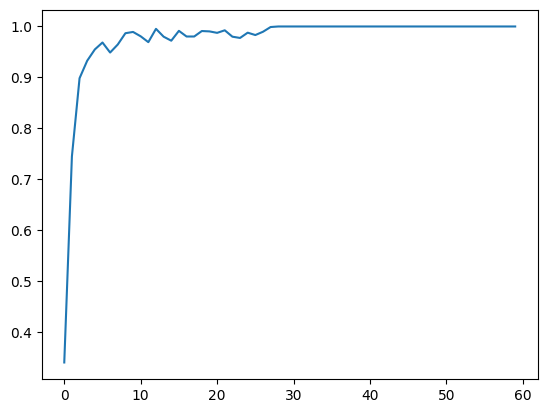

In [11]:
plt.plot(trafficSignNetwork.history['accuracy'], label='accuracy')

In [12]:
testing_data = []
for test_image_file in os.listdir(os.path.join( testingFolder)):
    testImage = Image.open(os.path.join(testingFolder, test_image_file))
    testImage = testImage.convert("L")
    testImage = testImage.resize((90,90))
    testImage = np.array(testImage)
    testing_data.append((testImage, [int(test_image_file[1:3])]))
testing_data_features, testing_data_labels = zip(*testing_data)
testing_data_features = np.array(testing_data_features)
testing_data_labels = np.array(testing_data_labels)

In [13]:
predictions = cnnModel.predict(testing_data_features)
predicted_labels = np.argmax(predictions, axis=1)

63/63 [==============================] - 1s 7ms/step


4     Speed limit (50km/h)
0      Speed limit (5km/h)
0      Speed limit (5km/h)
0      Speed limit (5km/h)
0      Speed limit (5km/h)
              ...         
23        Go Left or right
57                Unknown8
57                Unknown8
57                Unknown8
57                Unknown8
Name: Name, Length: 1994, dtype: object
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
             ...         
56               Unknown7
57               Unknown8
57               Unknown8
57               Unknown8
57               Unknown8
Name: Name, Length: 1994, dtype: object


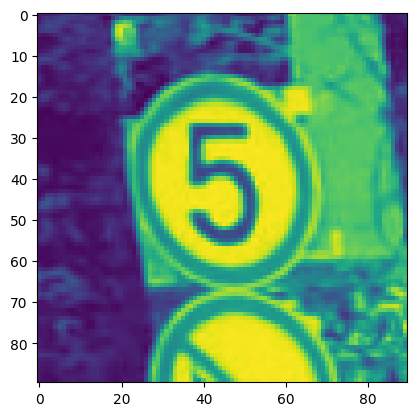

In [14]:
print(classes['Name'][predicted_labels])
print(classes['Name'][testing_data_labels[:,0]])
plt.imshow(testing_data_features[1])

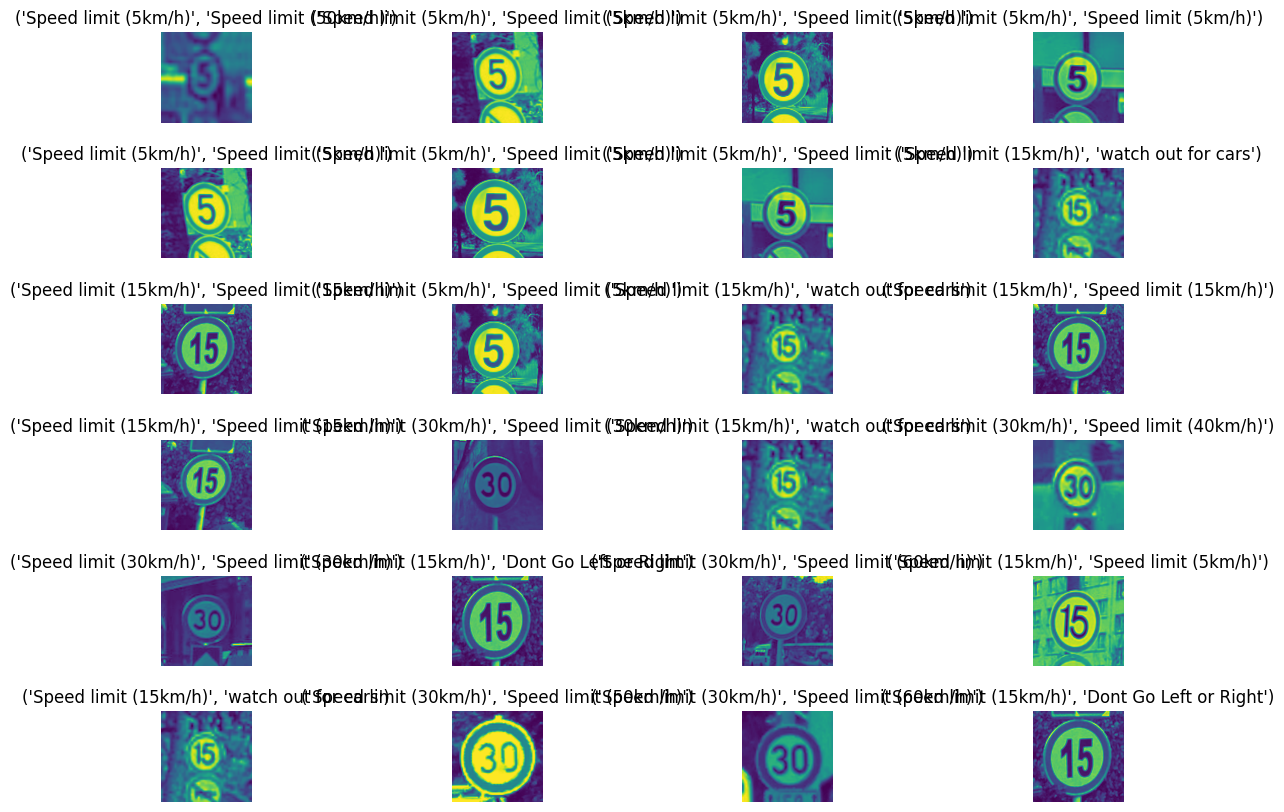

In [15]:
imageDisplayer(testing_data_features, testing_data_labels, predicted_labels)

In [16]:
test_loss, test_acc = cnnModel.evaluate(testing_data_features, testing_data_labels, verbose=2)
print(test_acc)

63/63 - 1s - loss: 5.3489 - accuracy: 0.5988 - 612ms/epoch - 10ms/step
0.5987963676452637


In [17]:
cnnModel.save('my_model.h5')